In [ ]:
# The PhD Job Market in Industry: A Data-Driven Analysis Using Revelio Data
#### By Elliot Oh

## How to Read This Notebook
# This notebook has four short analytical sections:
# 1. Industry outcomes by field
# 2. Occupation outcomes by field
# 3. Employer outcomes by field
# 4. Cross-field similarity (cosine similarity analysis)


# A short description:
# Motivation: PhD candidates face don't know about private sector career pathes. This notebook aims to describe career pathes and job competition for different fields.

# Data: Revelio Labs data provides provides firm-position level information for each individual along with ducation, occupation, and industry information. 
# Because Revelio Labs data is proprietary, this repository **does not** contain the underlying microdata. 
# Instead, this notebook presents **fully executed code and figures** that were run locally with licensed access.

# What questions the notebook answers: 
    # Where do PhDs work at? What industries, occupations, and companies?
    # Do PhDs from different fields compete against each other?
# Methodology: Exclude individuals with academic jobs. Calculate weighted average cosine similarity to compute competition among PhDs graduates across different fields.
# Answer: 
    # Substantial difference in share of graduates that work in academia by field
    # Substantial overlap in industry and occupation among graduates from different field.
    # PhD grads from different fields compete for same jobs (Many fields have high similarity score with other fields). 
    # Companies put little emphasis on domain expertise when hiring PhD graduates. Data scientist in finance = data scientist in tech.   

In [23]:
# Data Loading and variables
# This notebook assumes that the following preprocessed tables already exist on disk:
# - `phd_careers.parquet`: Tidy panel of **all positions** held after PhD completion (including academic + non-academic).

# Key columns used:
# - `user_id` – anonymized individual identifier  
# - `phd_cohortyear` – PhD completion year  
# - `field` – field of study (e.g., Engineering, Economics, Biology)  
# - `rics_k50` – LinkedIn industry classification  
# - `role_k1500_v2` – occupation classification  
# - `company` – employer name  
# - `position_startdate`, `position_enddate` – position start and end dates


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

plt.style.use("default")

# -------------------------------------------------------------------
# Paths (adjust these to your local setup before running)
# -------------------------------------------------------------------
DATA_DIR = "C:/Users/elliotoh/Box/lodes_shared/revelio/"     # where your parquet files live
FIG_DIR = "C:/Users/elliotoh/Box/lodes_shared/revelio/figures/"   # where figures will be saved

# Create dirs if needed
import os
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# -------------------------------------------------------------------
# Load preprocessed data
# -------------------------------------------------------------------
postphd_positions = pd.read_parquet(
    os.path.join(DATA_DIR, "phd_careers.parquet")
)

fields_order = [
    'Engineering', 'Business', 'Biology', 'Chemistry', 'Statistics',
    'Physics', 'Economics', 'Education', 'Mathematics', 'Medicine',
    'Finance', 'Marketing', 'Accounting', 'Architecture',
    'Information Technology'
]

keep_cols = ['user_id','position_id','position_startdate', 'position_enddate', 'field','role_k1500_v2', 'rcid', 'company', 'rics_k50', 'phd_cohortyear']
postphd_positions = postphd_positions[keep_cols]
postphd_positions.head()


,user_id,position_id,position_startdate,position_enddate,field,role_k1500_v2,rcid,company,rics_k50,phd_cohortyear
0,1000185.0,-7594451154502111232.0,2001-09-01,2002-08-01,Engineering,research scientist,289841.0,National Energy Technology Laboratory,Research and Development,2001
1,1000185.0,5318191364723391488.0,2001-09-01,2002-08-01,Engineering,research scientist,22143844.0,Carnegie Mellon University,Education Services,2001
2,1000185.0,-7395923350840898560.0,2002-09-01,2015-01-01,Engineering,scientist,20924380.0,"Honeywell International, Inc.",Engineering and Construction Services,2001
3,1001194.0,4870974300808686592.0,2003-09-01,2004-06-01,<NA>,writer,459036.0,Colby College,Education Services,2003
4,1001194.0,3154500422710195200.0,2004-01-01,2006-01-01,<NA>,teacher,629335.0,Harvard University,Education Services,2003


In [25]:
## Methodology
### Academic vs. non-academic positions
# We treat a position as **academic** if either:
# - The **industry** (`rics_k50`) contains:
#   - `Education Services` or `Research and Development`, or  
# - The **occupation title** (`role_k1500_v2`) matches patterns like:
#   - professor, research scientist, researcher, lecturer, teacher, etc.

# All other positions are treated as **non-academic** for the purpose of this notebook.
# The exact regex filters used are shown in the code cells below.


In [ ]:
def gen_academia_plot(y, data, title_text, file_text, fields):
    """
    Compute and plot the share of PhD grads in academia by field,
    for cohorts with phd_cohortyear >= y.

    Academia defined as industries containing Education Services or
    Research and Development (via rics_k50).
    """
    subset = data[data.phd_cohortyear >= y].copy()
    results = []

    for f in fields:
        subset1 = subset[(subset.field == f) & (subset.rics_k50.notnull())]

        academia = subset1[
            subset1.rics_k50.str.contains(
                "Education|Research and Development", na=False
            )
        ]
        pct_academia = (
            academia.shape[0] / subset1.shape[0]
            if subset1.shape[0] > 0
            else 0
        )
        results.append((f, pct_academia))

    df_plot = (
        pd.DataFrame(results, columns=["Field", "PctAcademia"])
        .sort_values("PctAcademia", ascending=False)
    )

    plt.figure(figsize=(8, 6))
    plt.barh(df_plot["Field"], df_plot["PctAcademia"])
    plt.xlabel("Share of PhDs in Academia")
    plt.title(f"Share of PhDs {title_text} in Academia (Cohorts ≥ {y})")
    plt.gca().invert_yaxis()
    plt.xlim(0, 1)
    plt.tight_layout()

    outpath = os.path.join(
        FIG_DIR,
        f"pct_academia_{file_text}_postphd_{y}.png"
    )
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"Saved figure to: {outpath}")
    return df_plot


def plot_top5_by_field(
    df,
    fields,
    year_cutoff,
    title_text,
    value_col,
    filter_series=None,
    filter_regex_exclude=None,
    xlim_range=None,
    filename="top5.png",
):
    """
    Generic helper to plot top-5 categories (value_col) by field.
    Each panel shows share of top 5 categories for that field.

    filter_series: df[column] to apply regex exclusion to (if provided)
    filter_regex_exclude: regex string to exclude rows (if provided)
    """
    # Apply year + null filters
    mask = (df["phd_cohortyear"] >= year_cutoff) & df[value_col].notnull()

    if filter_series is not None and filter_regex_exclude is not None:
        mask &= ~filter_series.str.contains(
            filter_regex_exclude, na=False, case=False
        )

    df2 = df[mask].copy()

    n_fields = len(fields)
    ncols = 3
    nrows = (n_fields + ncols - 1) // ncols

    fig, axes = plt.subplots(
        nrows, ncols, figsize=(18, 24), dpi=300, constrained_layout=True
    )
    axes = axes.flatten()

    for i, f in enumerate(fields):
        ax = axes[i]

        subset = df2[df2.field == f]
        n_obs = subset.shape[0]

        if n_obs > 0:
            vals = subset[value_col].value_counts().head(5) / n_obs
        else:
            vals = pd.Series(dtype=float)

        vals.sort_values().plot(kind="barh", ax=ax)

        ax.set_title(f"{f}\nN={n_obs}", fontsize=10)
        ax.invert_yaxis()
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis="both", labelsize=8)

        if xlim_range is not None:
            ax.set_xlim(xlim_range)

    # Delete extra axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title_text, fontsize=18)

    outpath = os.path.join(FIG_DIR, filename)
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved figure to: {outpath}")

def weighted_avg_cosine_by_field(
    df,
    year_cutoff,
    field_col,
    category_col,
    exclude_regex=None,
    pair_with=None,
):
    """
    Compute weighted avg cosine similarity by field.
    If pair_with is provided, filtering applies to both columns in the pair
    AND the combined string.
    """

    # -------------------
    # 0. Copy and create category variable
    # -------------------
    df2 = df.copy()

    if pair_with is not None:
        col1, col2 = pair_with

        # create combined category
        df2["pair_var"] = df2[col1].astype(str) + " | " + df2[col2].astype(str)
        cat_col = "pair_var"
    else:
        cat_col = category_col

    # -------------------
    # 1. Filtering
    # -------------------
    mask = (df2["phd_cohortyear"] >= year_cutoff) & df2[cat_col].notnull()

    if exclude_regex is not None:
        if pair_with is None:
            # Normal filtering
            mask &= ~df2[cat_col].str.contains(exclude_regex, na=False, case=False)
        else:
            # -------- Pair filtering --------
            # We filter out rows if either industry OR occupation OR combined contains regex
            mask &= ~(
                df2[col1].astype(str).str.contains(exclude_regex, na=False, case=False) |
                df2[col2].astype(str).str.contains(exclude_regex, na=False, case=False) |
                df2["pair_var"].str.contains(exclude_regex, na=False, case=False)
            )

    df2 = df2[mask].copy()

    if df2.empty:
        return pd.DataFrame()

    # -------------------
    # 2. Field sizes
    # -------------------
    field_sizes = df2.groupby(field_col).size()

    # -------------------
    # 3. Distribution matrix
    # -------------------
    dist = (
        df2.groupby([field_col, cat_col])
           .size()
           .unstack(fill_value=0)
    )
    dist = dist.div(dist.sum(axis=1), axis=0)

    # Remove duplicates if any
    if dist.index.duplicated().any():
        dupes = dist.index[dist.index.duplicated()].tolist()
        print("Duplicate field names detected (removed):", dupes)
        dist = dist[~dist.index.duplicated(keep="first")]

    fields = dist.index.tolist()

    # -------------------
    # 4. Cosine similarity
    # -------------------
    cos_matrix = pd.DataFrame(
        cosine_similarity(dist),
        index=fields,
        columns=fields
    )

    # -------------------
    # 5. Output results
    # -------------------
    results = {
        "field": [],
        "weighted_cosine_similarity": [],
        "n_grads": [],
        "top1_field": [], "top1_sim": [],
        "top2_field": [], "top2_sim": [],
        "top3_field": [], "top3_sim": [],
    }

    for f in fields:
        other_fields = [x for x in fields if x != f]
        sims = cos_matrix.loc[f, other_fields]
        weights = field_sizes.loc[other_fields]

        weighted_avg = np.average(sims.values, weights=weights.values)
        top3 = sims.sort_values(ascending=False).head(3)

        results["field"].append(f)
        results["weighted_cosine_similarity"].append(weighted_avg)
        results["n_grads"].append(field_sizes.loc[f])

        results["top1_field"].append(top3.index[0])
        results["top1_sim"].append(top3.iloc[0])
        results["top2_field"].append(top3.index[1])
        results["top2_sim"].append(top3.iloc[1])
        results["top3_field"].append(top3.index[2])
        results["top3_sim"].append(top3.iloc[2])

    return pd.DataFrame(results).sort_values(
        "weighted_cosine_similarity", ascending=False
    )


def weighted_avg_cosine_by_field_matched_indocc(
    df,
    year_cutoff,
    field_col="field",
    industry_col="rics_k50",
    role_col="role_k1500_v2"
):
    """
    Computes weighted average cosine similarity using industry–occupation pairs,
    with filtering logic EXACTLY matching the original function.
    """

    # -------------------
    # EXCLUSION PATTERNS (identical to original)
    # -------------------
    exclude_ind = "Education Services|Research and Development"
    exclude_occ = (
        "^professor$|^research$|^research scientist$|^researcher$|"
        "teach|lecturer|^scientist$|education|research engineer"
    )

    # -------------------
    # CREATE PAIR VARIABLE
    # -------------------
    df = df.copy()
    df["ind_occ_pair"] = df[industry_col] + " | " + df[role_col].astype(str)

    # -------------------
    # FILTERING (IDENTICAL TO ORIGINAL FUNCTION)
    # -------------------
    df2 = df[
        (df["phd_cohortyear"] >= year_cutoff) &
        df[industry_col].notnull() &
        df[role_col].notnull() &
        (~df[industry_col].str.contains(exclude_ind, na=False)) &
        (~df[role_col].str.contains(exclude_occ, na=False))
    ].copy()

    if df2.empty:
        return pd.DataFrame()

    # -------------------
    # FIELD SIZES (weights)
    # -------------------
    field_sizes = df2.groupby(field_col).size()

    # -------------------
    # DISTRIBUTION MATRIX (same as original)
    # -------------------
    pair_dist = (
        df2.groupby([field_col, "ind_occ_pair"])
           .size()
           .groupby(level=0)
           .apply(lambda x: x / x.sum())
           .unstack(fill_value=0)
    )

    # Flatten MultiIndex if any
    pair_dist.index = pair_dist.index.get_level_values(0)

    fields = pair_dist.index.tolist()

    # -------------------
    # COSINE SIMILARITY MATRIX
    # -------------------
    cos_matrix = pd.DataFrame(
        cosine_similarity(pair_dist),
        index=fields,
        columns=fields
    )

    # -------------------
    # RESULTS
    # -------------------
    results = {
        "field": [],
        "weighted_cosine_similarity": [],
        "n_grads": [],
        "top1_field": [], "top1_sim": [],
        "top2_field": [], "top2_sim": [],
        "top3_field": [], "top3_sim": [],
    }

    for f in fields:
        other_fields = [x for x in fields if x != f]
        sims = cos_matrix.loc[f, other_fields]
        weights = field_sizes.loc[other_fields]

        weighted_avg = np.average(sims.values, weights=weights.values)
        top3 = sims.sort_values(ascending=False).head(3)

        results["field"].append(f)
        results["weighted_cosine_similarity"].append(weighted_avg)
        results["n_grads"].append(field_sizes.loc[f])

        results["top1_field"].append(top3.index[0])
        results["top1_sim"].append(top3.iloc[0])
        results["top2_field"].append(top3.index[1])
        results["top2_sim"].append(top3.iloc[1])
        results["top3_field"].append(top3.index[2])
        results["top3_sim"].append(top3.iloc[2])

    return (
        pd.DataFrame(results)
          .sort_values("weighted_cosine_similarity", ascending=False)
          .reset_index(drop=True)
    )



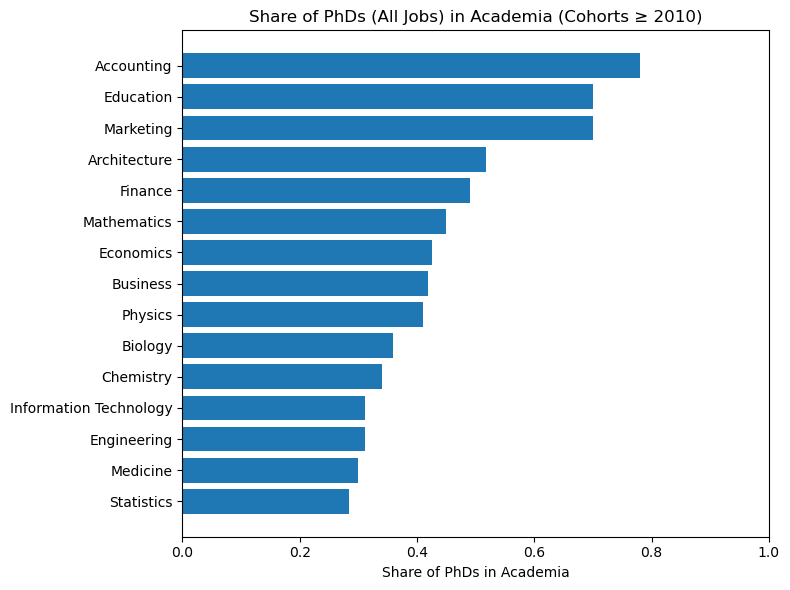

Saved figure to: C:/Users/elliotoh/Box/lodes_shared/revelio/figures/pct_academia_alljobs_postphd_2010.png


,Field,PctAcademia
12,Accounting,0.780269
7,Education,0.699807
11,Marketing,0.699320
13,Architecture,0.517777
10,Finance,0.490034
8,Mathematics,0.448919
6,Economics,0.425050
1,Business,0.418233
5,Physics,0.410751
2,Biology,0.358975


In [28]:
## Analysis I: Where do PhDs work after graduation?
# what share of PhD graduates are in academia versus non-academic roles**, by field of study.
# For all post-PhD jobs: postphd_positions

df_acad_all = gen_academia_plot(
    y=2010,
    data=postphd_positions,
    title_text="(All Jobs)",
    file_text="alljobs",
    fields=fields_order,
)
df_acad_all

### Interpretation
# - Fields like Accounting, education, and marketing have a higher (70+%) share of graduates in academic or research-oriented roles.
# - Fields such as architecture, finance, mathematics, economics, business, and physics  show a lower academic share (40-50%), reflecting a stronger orientation toward private-sector roles.
# - Chemistry, medicine, statistics, engineering, and information technology have the lowest (30%) share. 


In [ ]:
# Which industries do they work in?
title_all = "Top 5 Non-Academic Industries for PhD Graduates (All Jobs, Cohorts ≥ 2010)"

# Exclude academic industries
industry_exclude_regex = "Education Services|Research and Development"

# All jobs
plot_top5_by_field(
    df=postphd_positions,
    fields=fields_order,
    year_cutoff=2010,
    title_text=title_all,
    value_col="rics_k50",
    filter_series=postphd_positions["rics_k50"],
    filter_regex_exclude=industry_exclude_regex,
    xlim_range=(0, 0.5),
    filename="industries_by_field_alljobs.png",
)

### Interpretation

# - Graduates from engineering, business, statistics, physics, math, marketing, and information technology all commonly enter into Information Technology Services.
# - Graduates from business, biology, education, and medicine enter into Healthcare and Wellness
# - Graduates from biology, chemistry, and medicine commonly enter into Biotech and Pharmaceuticals. 
# - Graduates from finance, economics, and mathematics enter into Financial Services.
# - The patterns are similar when we look at all_jobs compared to only first jobs, suggesting that many PhDs remain in same sector after placement.



In [ ]:
# What occupations do they work in?
# Regex to exclude academic / research teaching roles
academic_roles_regex = (
    r"^professor$|^research$|^research scientist$|^researcher$|teach|"
    r"lecturer|^scientist$|education|research engineer"
)

title_occ_first = "Top 5 Non-Academic Occupations for PhD Graduates (First Job, Cohorts ≥ 2010)"
title_occ_all = "Top 5 Non-Academic Occupations for PhD Graduates (All Jobs, Cohorts ≥ 2010)"

# All jobs
plot_top5_by_field(
    df=postphd_positions,
    fields=fields_order,
    year_cutoff=2010,
    title_text=title_occ_all,
    value_col="role_k1500_v2",
    filter_series=postphd_positions["role_k1500_v2"],
    filter_regex_exclude=academic_roles_regex,
    xlim_range=(0, 0.5),
    filename="occupations_by_field_alljobs.png",
)

### Interpretation

# - 33% of positions still has overtly academic titles (professor, researcher, lecturer, etc.).
# - Once academic roles are excluded, we see PhDs working as:
#   - **Data scientists, quantitative researchers, and machine learning engineers**, especially from quantitative fields.
#   - **Consultants, product managers, and policy analysts** from business and social science fields.
# - Occupations that hire from many disciplines: data scientist (6 fields), quantitative analyst (6 fields), machine engineer and sofware engineer (4 fields). 
# - Suggests that PhD graduates from different fields may compete for same job.





In [ ]:
# Which firms do they work in?
academic_employer_regex = r"University|Institute|National Laboratory|School|College"

title_firm_first = "Top 5 Non-Academic Employers for PhD Graduates (First Job, Cohorts ≥ 2010)"
title_firm_all = "Top 5 Non-Academic Employers for PhD Graduates (All Jobs, Cohorts ≥ 2010)"

# All jobs
plot_top5_by_field(
    df=postphd_positions,
    fields=fields_order,
    year_cutoff=2010,
    title_text=title_firm_all,
    value_col="company",
    filter_series=postphd_positions["company"],
    filter_regex_exclude=academic_employer_regex,
    xlim_range=(0, 0.1),
    filename="firms_by_field_alljobs.png",
)

### Interpretation

# - Large tech firms employ PhD graduates from virtually all fields except biology, chemistry, education, medicine, and accounting. Potential competition among fields for same jobs. 
# - Wide array of government institutions also employ across wide fields including business, education, medicine, finance, and accounting. 
# - Some specialized hires: 
#   - large pharmaceuticals hire biology and chemistry PhDs
#   - economic consulting hires economics and finance PhDs
#   - semiconductor hires engineering and physics
#   - financial companies hire statistics, mathematics, finance PhD

In [46]:
# Average Cosine similarity for each field 
# 1) Industries (non-academic)
sim_industry = weighted_avg_cosine_by_field(
    df=postphd_positions,
    year_cutoff=2010,
    field_col="field",
    category_col="rics_k50",
    exclude_regex=industry_exclude_regex,
)
sim_industry

# Interpretation
# Graduates from most fields work in similar industries. Exceptions are finance and architecture.
# Doesn't necessarily mean competing for same job. 
# Possible: data scientist in tech vs. finance analyst in tech


,field,weighted_cosine_similarity,n_grads,top1_field,top1_sim,top2_field,top2_sim,top3_field,top3_sim
13,Physics,0.749728,30113,Engineering,0.936814,Information Technology,0.897295,Mathematics,0.885788
9,Information Technology,0.656785,1793,Mathematics,0.925179,Physics,0.897295,Business,0.816893
14,Statistics,0.654123,11439,Mathematics,0.865385,Physics,0.752782,Marketing,0.748848
3,Business,0.640738,34664,Information Technology,0.816893,Education,0.809578,Physics,0.769642
10,Marketing,0.639181,973,Mathematics,0.847757,Information Technology,0.810375,Physics,0.809398
11,Mathematics,0.627202,15724,Information Technology,0.925179,Physics,0.885788,Statistics,0.865385
7,Engineering,0.592644,239939,Physics,0.936814,Information Technology,0.768773,Marketing,0.752564
4,Chemistry,0.547545,58411,Biology,0.884048,Medicine,0.676350,Statistics,0.596032
12,Medicine,0.499426,4834,Biology,0.888028,Education,0.690531,Chemistry,0.676350
2,Biology,0.495138,54657,Medicine,0.888028,Chemistry,0.884048,Statistics,0.573854


In [47]:
# 2) Occupations (non-academic)
sim_occupation = weighted_avg_cosine_by_field(
    df=postphd_positions,
    year_cutoff=2010,
    field_col="field",
    category_col="role_k1500_v2",
    exclude_regex=academic_roles_regex,
)
sim_occupation

# Interpretation
# Physics and mathematics works in same occupations as all other areas. 
# Occupation-based score < industry-based score: Many grads work in same industry but different occupations.
# Data scientist in tech vs. data scientist in finance may require different domain expertise -> hire different candidate profile
# Need industry-occupation analysis to better understand competition for same jobs.


,field,weighted_cosine_similarity,n_grads,top1_field,top1_sim,top2_field,top2_sim,top3_field,top3_sim
13,Physics,0.519783,20168,Mathematics,0.961095,Statistics,0.824998,Engineering,0.716104
11,Mathematics,0.490581,12279,Physics,0.961095,Statistics,0.842643,Engineering,0.657894
14,Statistics,0.354852,8682,Mathematics,0.842643,Physics,0.824998,Engineering,0.406850
2,Biology,0.298329,24198,Medicine,0.600837,Chemistry,0.437107,Physics,0.388734
7,Engineering,0.292028,182747,Physics,0.716104,Mathematics,0.657894,Statistics,0.406850
9,Information Technology,0.271463,2128,Engineering,0.355313,Business,0.341243,Mathematics,0.253168
4,Chemistry,0.240540,29309,Biology,0.437107,Engineering,0.295182,Physics,0.234363
3,Business,0.227899,44628,Education,0.706154,Marketing,0.492931,Information Technology,0.341243
10,Marketing,0.205864,1435,Business,0.492931,Economics,0.353733,Finance,0.326613
8,Finance,0.174187,2642,Economics,0.931049,Accounting,0.646216,Marketing,0.326613


In [ ]:
# 3) Industry–occupation pairs
sim_indocc = weighted_avg_cosine_by_field_matched_indocc(postphd_positions, 2010)
sim_indocc

# How much competition is there beteen different fields for same job in same industry?
# Considerable competition among PhDs in different fields for same jobs. 
# Similarity score is very similar to occupation-level similarity score --> data scientist in tech firm not too different data scientist in finance firm. 
# PhD graduates applying for entry-level jobs. Technical skills > expertise in importance. Domain expertise less important.
# Domain expertise probably more important at senior levels. 


,field,weighted_cosine_similarity,n_grads,top1_field,top1_sim,top2_field,top2_sim,top3_field,top3_sim
0,Physics,0.527093,17930,Mathematics,0.890470,Statistics,0.692728,Engineering,0.692458
1,Mathematics,0.456673,10988,Physics,0.890470,Statistics,0.762719,Engineering,0.578064
2,Statistics,0.295609,7931,Mathematics,0.762719,Physics,0.692728,Finance,0.411742
3,Engineering,0.283001,161056,Physics,0.692458,Mathematics,0.578064,Information Technology,0.347083
4,Information Technology,0.246712,1656,Engineering,0.347083,Business,0.238951,Physics,0.238701
5,Chemistry,0.244420,25379,Biology,0.398051,Engineering,0.301637,Physics,0.253355
6,Biology,0.225077,19860,Medicine,0.683894,Chemistry,0.398051,Business,0.300288
7,Business,0.197213,30333,Education,0.687775,Medicine,0.318509,Biology,0.300288
8,Finance,0.165963,1832,Economics,0.727996,Mathematics,0.553962,Statistics,0.411742
9,Medicine,0.136125,2542,Biology,0.683894,Education,0.320819,Business,0.318509


In [ ]:
# 4) Firm–occupation pairs (non-academic employers + non-academic roles)
firmocc_exclude_regex = (
    academic_employer_regex + "|" + academic_roles_regex
)
sim_firmocc = weighted_avg_cosine_by_field(
    df=postphd_positions,
    year_cutoff=2010,
    field_col="field",
    category_col=None,
    exclude_regex=firmocc_exclude_regex,
    pair_with=("company", "role_k1500_v2"),
)
sim_firmocc

### Interpretation
# - Score (firm-occupation) similar to score (industry-occupation) -> Competing for same jobs in same firm.
# - PhDs holders are competing for same positions within the same firm. -> Greater competition at larger and more prestigious companies.


,field,weighted_cosine_similarity,n_grads,top1_field,top1_sim,top2_field,top2_sim,top3_field,top3_sim
13,Physics,0.498651,18975,Engineering,0.714490,Mathematics,0.680397,Chemistry,0.410661
11,Mathematics,0.472483,11574,Engineering,0.714003,Physics,0.680397,Statistics,0.451837
7,Engineering,0.267058,171707,Physics,0.714490,Mathematics,0.714003,Chemistry,0.343705
4,Chemistry,0.257456,26989,Physics,0.410661,Engineering,0.343705,Biology,0.231239
2,Biology,0.211622,21095,Medicine,0.340396,Business,0.305864,Education,0.269940
14,Statistics,0.184740,8134,Mathematics,0.451837,Physics,0.344615,Engineering,0.231338
6,Education,0.157952,12417,Business,0.709630,Medicine,0.364667,Biology,0.269940
3,Business,0.151663,38092,Education,0.709630,Accounting,0.419981,Marketing,0.379264
9,Information Technology,0.144056,1850,Business,0.230698,Education,0.174921,Engineering,0.164976
8,Finance,0.132090,2152,Economics,0.456313,Business,0.316767,Accounting,0.234465
